# RBM

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [0]:
import tensorflow as tf

Load the ratings dataset.

In [0]:
!wget "https://drive.google.com/uc?export=download&id=1k-1uPww4lWAQ-cQlUHmdsYTmE_J_yOTz" -O users_without_dubs.csv

In [6]:
ratings = pd.read_csv('users_without_dubs.csv')
ratings.head()

,Unnamed: 0,gameid,username,rating
0,0,2105,Metro123,10.0
1,1,2105,BoardGamer2008,10.0
2,2,2105,gruenspan47,9.9
3,3,2105,moxtaveto,9.0
4,4,2105,Mazoon,9.0


In [0]:
users = np.unique(ratings.username).astype(str)
userssId = {user: i for  i, user in enumerate(users)}


In [8]:
ratings.username = [userssId[user] for user in ratings.username.astype(str)]
ratings.gameid = ratings.gameid.astype(str).astype(int)
ratings.rating = ratings.rating.astype(str).astype(float)
ratings.head()

,Unnamed: 0,gameid,username,rating
0,0,2105,15037,10.0
1,1,2105,2737,10.0
2,2,2105,35220,9.9
3,3,2105,42279,9.0
4,4,2105,14830,9.0


In [9]:
gameIndex = ratings.groupby("gameid").count().sort_values(by="rating",ascending=False)[0:10000].index
ratings2 = ratings[ratings.gameid.isin(gameIndex)]
ratings2.count()

Unnamed: 0    1822888
gameid        1822888
username      1822888
rating        1822888
dtype: int64

In [13]:
userIndex = ratings2.groupby("username").count().sort_values(by="rating",ascending=False).sample(n=10000, random_state=1234).index
ratings3 = ratings2[ratings2.username.isin(userIndex)]
ratings3.count()

Unnamed: 0    342114
gameid        342114
username      342114
rating        342114
dtype: int64

reindex gameID and userID to a range of 1 to num_games, num_users

In [14]:
games = ratings3.gameid.unique()
gamesDF = pd.DataFrame(data=games,columns=['originalGameId'])
gamesDF['newGameId'] = gamesDF.index+1

users = ratings3.username.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

ratingDF = ratings3.merge(gamesDF,left_on='gameid',right_on='originalGameId')
ratingDF.drop(labels='originalGameId', axis=1, inplace=True)

ratingDF = ratingDF.merge(usersDF,left_on='username',right_on='originalUserId')
ratingDF.drop(labels='originalUserId', axis=1, inplace=True)

ratingDF.head()

,Unnamed: 0,gameid,username,rating,newGameId,newUserId
0,13,2105,42413,8.0,1,1
1,6724,6474,42413,4.0,74,1
2,8165,57458,42413,7.0,90,1
3,18868,1390,42413,5.0,208,1
4,19411,2824,42413,5.0,214,1


In [15]:
n_users = ratingDF.username.unique().shape[0]
n_games = ratingDF.gameid.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique games: ', n_games)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  10000
Number of unique games:  10000
Number of total ratings:  342114
Average number of ratings per user:  34.2114


Let’s generate a test set and a validation set from the dataset so that each holdout set is 5% of the dataset.

In [0]:
X_train, X_test = train_test_split(ratingDF, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

Let’s create a matrix m x n, where m are the users and n are the games. This will be a sparsely populated matrix because users rate only a fraction of the games.

Generate ratings matrix for train.

In [0]:
ratings_train = np.zeros((n_users, n_games))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[4]

Calculate sparsity of the train ratings matrix.

In [18]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.31%


Generate ratings matrix for validation.

In [0]:
ratings_validation = np.zeros((n_users, n_games))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[4]

Generate ratings matrix for test.

In [0]:
ratings_test = np.zeros((n_users, n_games))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[4]

Calculate sparsity of the validation ratings matrix.

In [21]:
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.02%


Define RBM class.

In [0]:
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [23]:
ratings_train.shape

(10000, 10000)

In [0]:
#Begin the training cycle
# Convert inputX into float32
inputX = ratings_train.astype(np.float32)


# Define the parameters of the RBMs we will train
rbm=RBM(10000, 10000, 0.3, 20, 200)

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [30]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 0.222729
Epoch: 1 reconstruction error: 0.208655
Epoch: 2 reconstruction error: 0.201015
Epoch: 3 reconstruction error: 0.196895
Epoch: 4 reconstruction error: 0.194520
Epoch: 5 reconstruction error: 0.193139
Epoch: 6 reconstruction error: 0.192285
Epoch: 7 reconstruction error: 0.191824
Epoch: 8 reconstruction error: 0.191461
Epoch: 9 reconstruction error: 0.191075
Epoch: 10 reconstruction error: 0.190854
Epoch: 11 reconstruction error: 0.190697
Epoch: 12 reconstruction error: 0.190585
Epoch: 13 reconstruction error: 0.190404
Epoch: 14 reconstruction error: 0.190320
Epoch: 15 reconstruction error: 0.190220
Epoch: 16 reconstruction error: 0.190150
Epoch: 17 reconstruction error: 0.190103
Epoch: 18 reconstruction error: 0.190027
Epoch: 19 reconstruction error: 0.189967


Text(0, 0.5, 'Reconstruction Error')

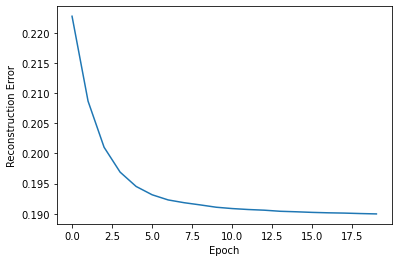

In [31]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [0]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

In [33]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 53.6370220885529
